In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

--2019-11-05 15:48:34--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 2404:6800:4008:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M  44.7MB/s    in 3.2s    

2019-11-05 15:48:38 (44.7 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]



The following python code will use the OS library to use Operating System libraries, giving you access to the file system, and the zipfile library allowing you to unzip the data. 

In [0]:
import os
import zipfile

In [0]:
local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')
zip_ref.close()
os.remove(local_zip)

In [5]:
!ls /tmp

horse-or-human


The contents of the .zip are extracted to the base directory `/tmp/horse-or-human`, which in turn each contain `horses` and `humans` subdirectories.

In short: The training set is the data that is used to tell the neural network model that 'this is what a horse looks like', 'this is what a human looks like' etc. 

One thing to pay attention to in this sample: We do not explicitly label the images as horses or humans. If you remember with the handwriting example earlier, we had labelled 'this is a 1', 'this is a 7' etc.  Later you'll see something called an ImageGenerator being used -- and this is coded to read images from subdirectories, and automatically label them from the name of that subdirectory. So, for example, you will have a 'training' directory containing a 'horses' directory and a 'humans' one. ImageGenerator will label the images appropriately for you, reducing a coding step. 

Let's define each of these directories:

In [0]:
# Directory with our training horse pictures
train_horse_dir = os.path.join('/tmp/horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('/tmp/horse-or-human/humans')

Now, let's see what the filenames look like in the `horses` and `humans` training directories:

In [7]:
train_horse_names = os.listdir(train_horse_dir)
train_human_names = os.listdir(train_human_dir)
for hu, ho in zip(train_horse_names[:10],train_human_names[:10]):
  print(hu, '|', ho)

horse42-0.png | human15-12.png
horse25-6.png | human11-03.png
horse33-9.png | human06-07.png
horse37-6.png | human15-30.png
horse47-9.png | human16-28.png
horse11-7.png | human03-03.png
horse41-5.png | human17-20.png
horse32-1.png | human08-15.png
horse30-3.png | human01-05.png
horse32-8.png | human06-15.png


Let's find out the total number of horse and human images in the directories:

In [8]:
print('total training horse images:', len(os.listdir(train_horse_dir)))
print('total training human images:', len(os.listdir(train_human_dir)))

total training horse images: 500
total training human images: 527


Now let's take a look at a few pictures to get a better sense of what they look like. First, configure the matplot parameters:

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Now, display a batch of 8 horse and 8 human pictures. You can rerun the cell to see a fresh batch each time:

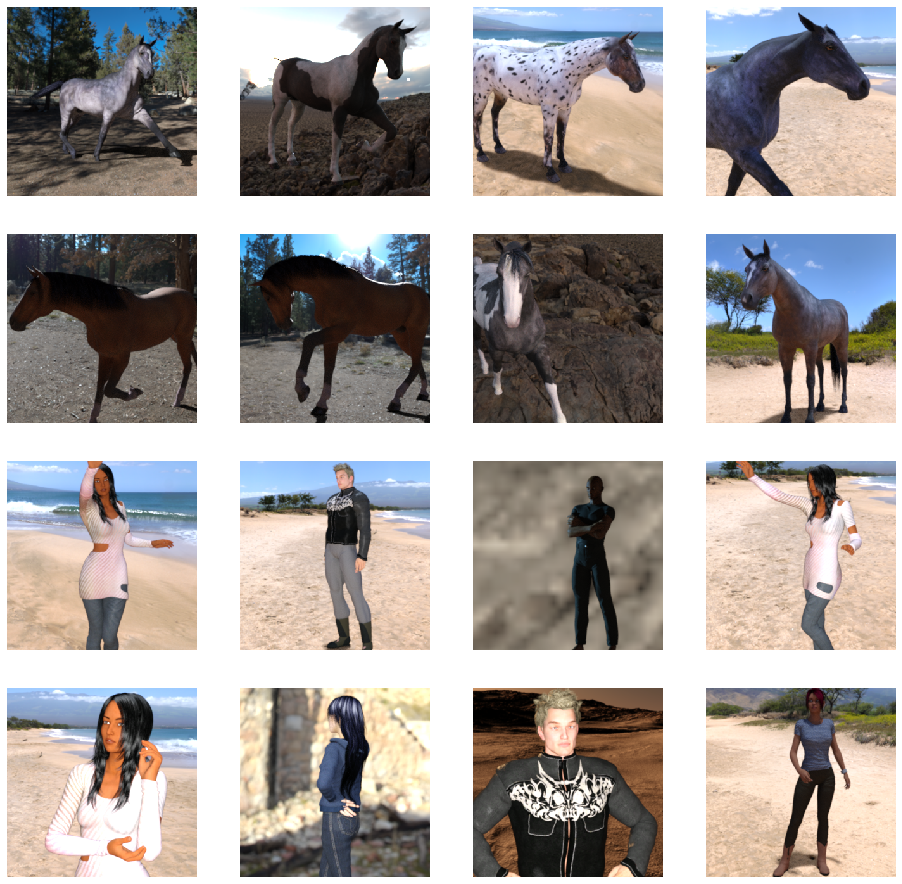

In [10]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname) 
                  for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname) 
                  for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
  # Set up subplot; subplot indices start at 1
  # (third argument enumerates which subplot to use)
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## Building a Small Model from Scratch

But before we continue, let's start defining the model:

Step 1 will be to import tensorflow.

In [0]:
import tensorflow as tf

We then add convolutional layers as in the previous example, and flatten the final result to feed into the densely connected layers.

Finally we add the densely connected layers. 

Note that because we are facing a two-class classification problem, i.e. a *binary classification problem*, we will end our network with a [*sigmoid* activation](https://wikipedia.org/wiki/Sigmoid_function), so that the output of our network will be a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0).

In [12]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), 
                           activation='relu', 
                           input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), 
                           activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), 
                           activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), 
                           activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), 
                           activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, 
                          activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, 
                          activation='sigmoid')
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


The model.summary() method call prints a summary of the NN 

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        3

The "output shape" column shows how the size of your feature map evolves in each successive layer. The convolution layers reduce the size of the feature maps by a bit due to padding, and each pooling layer halves the dimensions.

Next, we'll configure the specifications for model training. We will train our model with the `binary_crossentropy` loss, because it's a binary classification problem and our final activation is a sigmoid. (For a refresher on loss metrics, see the [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/descending-into-ml/video-lecture).) We will use the `rmsprop` optimizer with a learning rate of `0.001`. During training, we will want to monitor classification accuracy.

**NOTE**: In this case, using the [RMSprop optimization algorithm](https://wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) is preferable to [stochastic gradient descent](https://developers.google.com/machine-learning/glossary/#SGD) (SGD), because RMSprop automates learning-rate tuning for us. (Other optimizers, such as [Adam](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam) and [Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad), also automatically adapt the learning rate during training, and would work equally well here.)

In [14]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Data Preprocessing

Let's set up data generators that will read pictures in our source folders, convert them to `float32` tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the validation images. Our generators will yield batches of images of size 300x300 and their labels (binary).

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In our case, we will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).

In Keras this can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. This `ImageDataGenerator` class allows you to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. These generators can then be used with the Keras model methods that accept data generators as inputs: `fit_generator`, `evaluate_generator`, and `predict_generator`.

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
                      '/tmp/horse-or-human/',  # This is the source directory for training images
                      target_size=(300, 300),  # All images will be resized to 300x300
                      batch_size=128,
                      # Since we use binary_crossentropy loss, we need binary labels
                      class_mode='binary')

Found 1027 images belonging to 2 classes.


### Training
Let's train for 15 epochs -- this may take a few minutes to run.

Do note the values per epoch.

The Loss and Accuracy are a great indication of progress of training. It's making a guess as to the classification of the training data, and then measuring it against the known label, calculating the result. Accuracy is the portion of correct guesses. 

In [16]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=8,  
                              epochs=15,
                              verbose=1)

Epoch 1/15
8/8 [==============================] - 10s 1s/step - loss: 0.7256 - acc: 0.5339
Epoch 2/15
8/8 [==============================] - 7s 895ms/step - loss: 0.6594 - acc: 0.5674
Epoch 3/15
8/8 [==============================] - 6s 752ms/step - loss: 1.2046 - acc: 0.7093
Epoch 4/15
8/8 [==============================] - 8s 943ms/step - loss: 0.4215 - acc: 0.8369
Epoch 5/15
8/8 [==============================] - 7s 841ms/step - loss: 0.1591 - acc: 0.9355
Epoch 6/15
8/8 [==============================] - 7s 856ms/step - loss: 0.4706 - acc: 0.8565
Epoch 7/15
8/8 [==============================] - 7s 854ms/step - loss: 0.1669 - acc: 0.9511
Epoch 8/15
8/8 [==============================] - 7s 851ms/step - loss: 0.0907 - acc: 0.9577
Epoch 9/15
8/8 [==============================] - 7s 844ms/step - loss: 0.1496 - acc: 0.9499
Epoch 10/15
8/8 [==============================] - 7s 848ms/step - loss: 0.0849 - acc: 0.9611
Epoch 11/15
8/8 [==============================] - 7s 857ms/step - loss

###Running the Model

Let's now take a look at actually running a prediction using the model. This code will allow you to choose 1 or more files from your file system, it will then upload them, and run them through the model, giving an indication of whether the object is a horse or a human.

In [26]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()
print()

for fn in uploaded.keys():
 
  # transform images to appropriately dimensioned array
  path = '/content/' + fn
  img = image.load_img(path, target_size=(300, 300))

  x = image.img_to_array(img)
  print('image shape before:', x.shape)
  x = np.expand_dims(x, axis=0)
  print('image shape after:', x.shape)
  #images = np.vstack([x])

  # using model
  classes = model.predict(x, batch_size=10)

  print('model prediction:', classes[0])
  if classes[0]>0.5:
    print(fn + " is a human")
  else:
    print(fn + " is a horse")
  print('-'*40)

Saving human8.jpg to human8.jpg
Saving human7.jpeg to human7.jpeg
Saving human5.jpg to human5.jpg
Saving human3.jpg to human3.jpg
Saving human2.jpg to human2.jpg
Saving human.jpg to human.jpg
Saving horse3.jpg to horse3.jpg
Saving horse2.png to horse2.png
Saving horse.jpg to horse.jpg
Saving horse-galloping-in-grass-688899769-587673275f9b584db3a44cdf.jpg to horse-galloping-in-grass-688899769-587673275f9b584db3a44cdf.jpg

image shape before: (300, 300, 3)
image shape after: (1, 300, 300, 3)
model prediction: [0.]
human8.jpg is a horse
----------------------------------------
image shape before: (300, 300, 3)
image shape after: (1, 300, 300, 3)
model prediction: [0.]
human7.jpeg is a horse
----------------------------------------
image shape before: (300, 300, 3)
image shape after: (1, 300, 300, 3)
model prediction: [0.]
human5.jpg is a horse
----------------------------------------
image shape before: (300, 300, 3)
image shape after: (1, 300, 300, 3)
model prediction: [1.]
human3.jpg is

In [27]:
test = image.load_img('/content/human.jpg', target_size=(300, 300))
test = image.img_to_array(test)
print('image shape before:', test.shape)
test = np.expand_dims(test, axis=0)
print('image shape after:', test.shape)
#print(test)
print('--------------------------------------------------')
x = np.vstack([test])
print('all images stacked:', x.shape)
#print(test)

image shape before: (300, 300, 3)
image shape after: (1, 300, 300, 3)
--------------------------------------------------
all images stacked: (1, 300, 300, 3)


In [28]:
for key, item in uploaded.items():
  print(key, '| size:', len(item))

human8.jpg | size: 25041
human7.jpeg | size: 8199
human5.jpg | size: 136651
human3.jpg | size: 55830
human2.jpg | size: 227496
human.jpg | size: 454677
horse3.jpg | size: 28441
horse2.png | size: 72929
horse.jpg | size: 44917
horse-galloping-in-grass-688899769-587673275f9b584db3a44cdf.jpg | size: 1537717


In [29]:
!ls /content

horse2.png							 human5.jpg
horse3.jpg							 human7.jpeg
horse-galloping-in-grass-688899769-587673275f9b584db3a44cdf.jpg  human8.jpg
horse.jpg							 human.jpg
human2.jpg							 sample_data
human3.jpg


In [25]:
!rm /content/*

rm: cannot remove '/content/sample_data': Is a directory


### Visualizing Intermediate Representations

To get a feel for what kind of features our convnet has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the convnet.

Let's pick a random image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.

In [30]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
print('layers:')
print(*successive_outputs, sep='\n')
print()

layers:
Tensor("max_pooling2d/MaxPool:0", shape=(?, 149, 149, 16), dtype=float32)
Tensor("conv2d_1/Relu:0", shape=(?, 147, 147, 32), dtype=float32)
Tensor("max_pooling2d_1/MaxPool:0", shape=(?, 73, 73, 32), dtype=float32)
Tensor("conv2d_2/Relu:0", shape=(?, 71, 71, 64), dtype=float32)
Tensor("max_pooling2d_2/MaxPool:0", shape=(?, 35, 35, 64), dtype=float32)
Tensor("conv2d_3/Relu:0", shape=(?, 33, 33, 64), dtype=float32)
Tensor("max_pooling2d_3/MaxPool:0", shape=(?, 16, 16, 64), dtype=float32)
Tensor("conv2d_4/Relu:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("max_pooling2d_4/MaxPool:0", shape=(?, 7, 7, 64), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 3136), dtype=float32)
Tensor("dense/Relu:0", shape=(?, 512), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 1), dtype=float32)



In [0]:
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

In [32]:
# Let's prepare a random input image from the training set.
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

print('random image:', img_path)
print()

random image: /tmp/horse-or-human/horses/horse21-0.png



In [34]:
img = load_img(img_path, target_size=(300, 300))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (300, 300, 3)
x = np.expand_dims(x, axis=0)  # Numpy array with shape (1, 300, 300, 3)
# Rescale by 1/255
x /= 255
print(x.shape)

(1, 300, 300, 3)


In [40]:
# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)
for x in successive_feature_maps:
  print(np.array(x).shape)

(1, 149, 149, 16)
(1, 147, 147, 32)
(1, 73, 73, 32)
(1, 71, 71, 64)
(1, 35, 35, 64)
(1, 33, 33, 64)
(1, 16, 16, 64)
(1, 14, 14, 64)
(1, 7, 7, 64)
(1, 3136)
(1, 512)
(1, 1)


In [41]:
# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]
[print(n) for n in layer_names]

conv2d
max_pooling2d
conv2d_1
max_pooling2d_1
conv2d_2
max_pooling2d_2
conv2d_3
max_pooling2d_3
conv2d_4
max_pooling2d_4
flatten
dense
dense_1


[None, None, None, None, None, None, None, None, None, None, None, None, None]

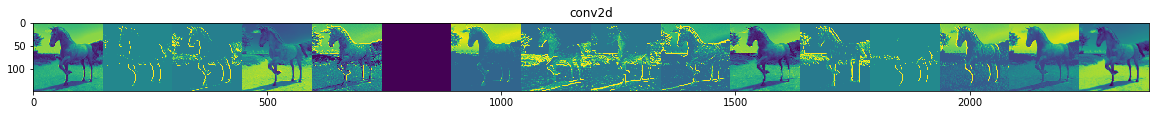

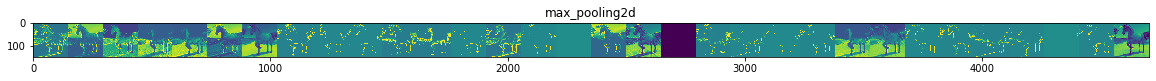

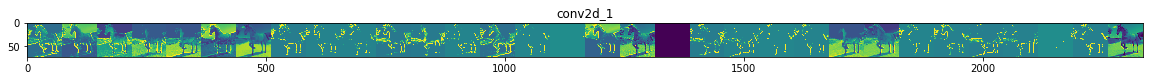

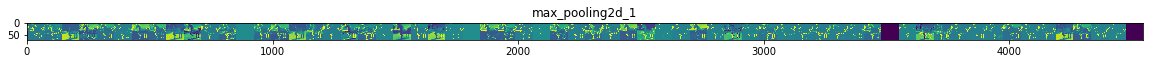

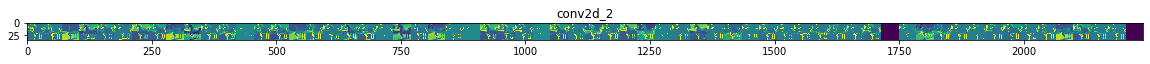

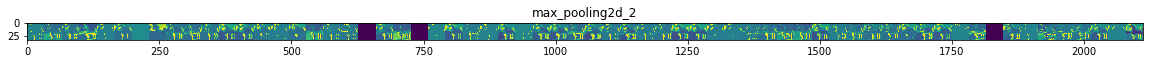

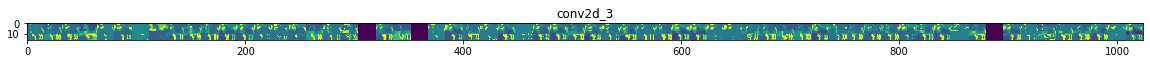

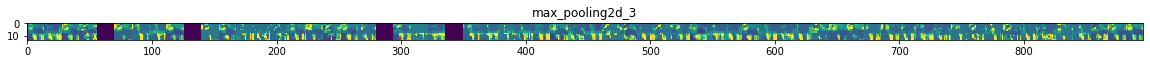

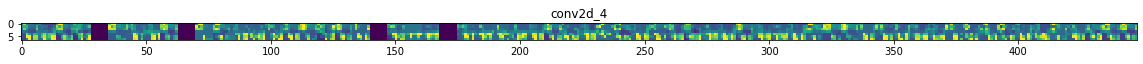

In [45]:
# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  # Just do this for the conv / maxpool layers, not the fully-connected layers
  if len(feature_map.shape) == 4:
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      # normalize
      x -= x.mean()
      x /= x.std()
      # ??
      x *= 64
      x += 128
      # clip to rgb
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

As you can see we go from the raw pixels of the images to increasingly abstract and compact representations. The representations downstream start highlighting what the network pays attention to, and they show fewer and fewer features being "activated"; most are set to zero. This is called "sparsity." Representation sparsity is a key feature of deep learning.


These representations carry increasingly less information about the original pixels of the image, but increasingly refined information about the class of the image. You can think of a convnet (or a deep network in general) as an information distillation pipeline.

## Clean Up

Before running the next exercise, run the following cell to terminate the kernel and free memory resources:

In [0]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)